# **Table of Contents**

* [Abstract](#section1)
* [Exploratory Data Analysis (EDA)](#section2)
    * [By Country](#section2a)
    * [By Customer](#section2b)
    * [By Transaction](#section2c)
    * [By Product](#section2d)
    * [By Date](#section2e)
* [Product Clustering](#section3)
    * [PCA](#section3a)
    * [Clustering](#section3b)
* [Customer Clustering](#section4)
    * [PCA](#section4a)
    * [Clustering](#section4b)
* [Customer Classification](#section5)

<a id="section1"></a>
# Abstract

The goal of this project was to cluster customers of a UK-based e-commerce retailer and create a model that will classify customers based on their purchase history on the site. A dataset of over 500,000 user transactions, between 01/12/2010 and 09/12/2011, were analyzed courtesy of the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Online+Retail#). The customers were clustered into 5 primary groups based on the types of products they bought and a Logistic Regression model waas built to classify these customers with 100% accuracy. Using the findings, and the model produced, one could create a personalized ad campaign recommending users specific items based on what they have purchased in the past. Further analysis could be done to add additional features to the model to further segment customers by their spending habits.

<a id="section2"></a>
# Exploratory Data Analysis (EDA)

In [825]:
# Importing all of the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import warnings
import math
from geopy.geocoders import Nominatim
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix
import nltk 
from nltk.corpus import stopwords
import re 
import heapq 
from wordcloud import WordCloud
import random

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
%matplotlib inline

In [676]:
list(range(5))

[0, 1, 2, 3, 4]

In [262]:
# All of the functions used in this analysis

def bar_plot(df, x, y, xlabel, ylabel, title, xrotate=20, horizontal=False):
    
    '''
    Creates a bar graph 
    
    Args:
        df: A dataframe
        x: str; The name of column to use for the x-axis
        y: str; The name of column to use for the y-axis
        xlabel: str; The name to give the x-axis
        ylabel: str; The name to give the y-axis
        title: str; The title to give the plot
        xrotate: int; How much to rotate the x-axis labels; default 20
    Returns:
        A bar graph
    '''
    if horizontal==False:
        plt.figure(figsize=(16,8))
    else:
        plt.figure(figsize=(16,12))
    plt.rcParams.update({'font.size': 16})
    plt.xticks(rotation=xrotate);

    sns.barplot(x = df[x], y = df[y]);
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);
    plt.title(title);
    

def freq_plot(df, col_name, title=None, x_label=None, y_label=None, bins=100):
    '''
    Get a frequency plot, for a specific column, in a 
    dataframe.
    
    Args:
        df: A dataframe
        col_name: The column of interest
        title: The title to provide the plot, defaults to "Frequency of col_name"
        x_label: The label of the x-axis, defaults to col_name
        y_label: The label of the y-axis, defaults to "Frequency"
        bins: Number of bins to use; defaults to 100
    Returns:
        None
    '''
    if x_label == None:
        x_label = col_name
    if y_label == None:
        y_label = "Frequency"
    if title == None:
        title = f"Frequency of {col_name}"
        
    plt.rcParams.update({'font.size': 16})

    plt.figure(figsize=(16,8))
    plt.hist(df[col_name], bins = bins)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()


def map_choropleth(df):
    
    '''
    Creates a Choropleth graph 
    
    Args:
        df: A dataframe
    Returns:
        A Choropleth map
    '''

    fig = go.Figure(data=go.Choropleth(
        locations = df['Country'],
        locationmode = "country names",
        z = df['InvoiceNo'],
        text = df['Country'],
        colorscale = 'Blues',
        autocolorscale=False,
        reversescale=False,
        marker_line_color='darkgray',
        marker_line_width=0.5,
        # colorbar_tickprefix = '$',
        colorbar_title = 'Purchases',
    ))

    fig.update_layout(
        title_text='TITLE',
        geo=dict(
            showframe=False,
            showcoastlines=False,
            projection_type='equirectangular'
        ),
        annotations = [dict(
            x=0.55,
            y=0.1,
            xref='paper',
            yref='paper',
            # text='Source: <a href="https://www.cia.gov/library/publications/the-world-factbook/fields/2195.html">\
                #CIA World Factbook</a>',
            showarrow = False
        )]
    )

    fig.show()

    
def assign_class(x):
    
    '''
    Binning products based on price
    '''
    
    if x < 1:
        return 'class_1'
    elif x >= 1 and x < 2:
        return 'class_2'
    elif x >= 2 and x < 3:
        return 'class_3'
    elif x >= 3 and x < 5:
        return 'class_4'
    elif x >= 5 and x < 10:
        return 'class_5'
    else:
        return 'class_6'
    
    
def desc_to_words(desc):
    
    '''
    Convert a raw description to a string of words
    
    Args:
        desc: str; A product description
    Returns:
        str; A processing description string
    '''
    # Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", desc) 
    
    # Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    
    # Get stop words and convert to set for faster searching
    stops = set(stopwords.words("english"))                  
    
    # Remove stop words
    meaningful_words = [w for w in words if not w in stops] 
    
    # Remove 
    
    # Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))

In [2]:
# Reading in the data

df = pd.read_csv('data/online_retail.csv')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [4]:
df.shape

(541909, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


According to the data description, here are the details for each column and what they represent.

**InvoiceNo:** Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

**StockCode:** Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

**Description:** Product (item) name. Nominal.

**Quantity:** The quantities of each product (item) per transaction. Numeric.

**InvoiceDate:** Invice Date and time. Numeric, the day and time when each transaction was generated.

**UnitPrice:** Unit price. Numeric, Product price per unit in sterling.

**CustomerID:** Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

**Country:** Country name. Nominal, the name of the country where each customer resides.

In [7]:
# Let's take a look at the number of NULL values in the dataframe

df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

It seems like the *'Description'* and *'CustomerID'* columns are the only fields harboring NULL values. CustomerID is a crucial piece of information to be missing and the total records missing this piece of information make up almost 1/5 of the entire data set. For this reason, we will keep the records in the dataset but exercise caution as we move along with our analysis. At some times, it may be easier to analyze the data without the NULL values, so we will create a separate dataframe with these records removed. 

Let's now continue by analyzing each of the columns, keeping the business context in mind.

In [8]:
# Let's make a few changes to the columns before we continue

df['CustomerID'] = df['CustomerID'].apply(lambda x: int(x) if ~np.isnan(x) else x)
df['StockCode'] = df['StockCode'].apply(lambda x: x.strip())
df['Country'] = df['Country'].apply(lambda x: x.strip())
df['InvoiceDate'] = df['InvoiceDate'].apply(lambda x: x.strip().split(' ')[0])

In [9]:
trunc_df = df[~df['CustomerID'].isna()].reset_index(drop=True)

In [10]:
trunc_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10,3.39,17850.0,United Kingdom


In [11]:
trunc_df.shape

(406829, 8)

<a id="section2a"></a>
## Country

Let's explore the following metrics broken down by country:

* Number of unique purchases (discount/non-discount)
* Total amount of money earned from each country
* Total unique customers in each country

In [47]:
# Seperating returns and non-returns

non_return_df = trunc_df[~trunc_df['InvoiceNo'].str.contains("C")].reset_index(drop=True)
return_df = trunc_df[trunc_df['InvoiceNo'].str.contains("C")].reset_index(drop=True)

In [56]:
purchases = pd.DataFrame(non_return_df.groupby(['Country','Latitude','Longitude'])['InvoiceNo']
                                      .nunique()
                                      .reset_index(drop=False))

In [57]:
purchases.head()

,Country,Latitude,Longitude,InvoiceNo
0,Australia,-24.7761086,134.755,57
1,Austria,47.2000338,13.199959,17
2,Bahrain,26.1551249,50.5344606,2
3,Belgium,50.6402809,4.6667145,98
4,Brazil,-10.3333333,-53.2,1


In [ ]:
top_purchases = purchases.sort_values('InvoiceNo', ascending=False).head(10).reset_index()

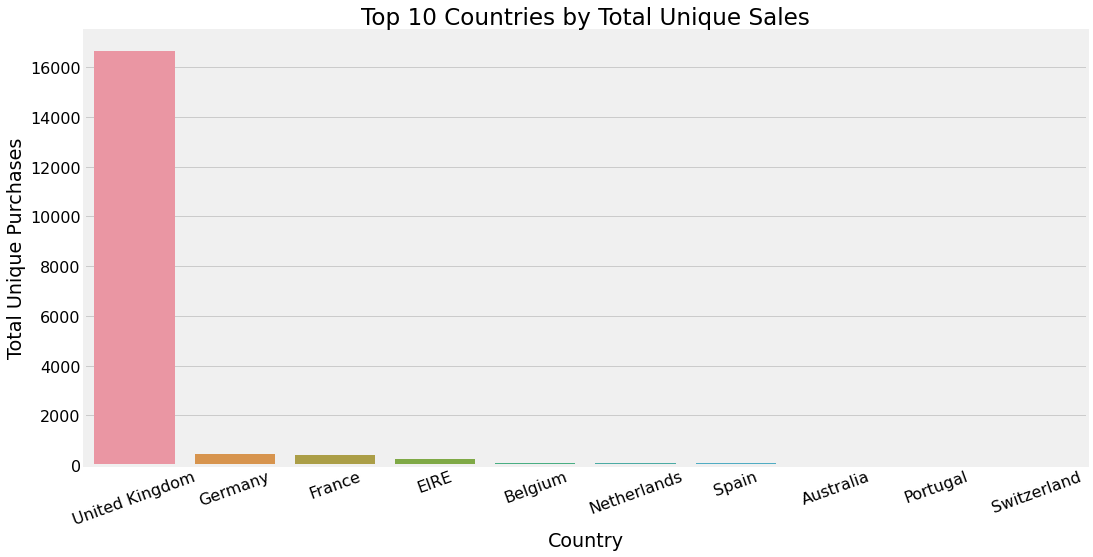

In [118]:
bar_plot(top_purchases, "Country", "InvoiceNo", "Country", "Total Unique Purchases", 
         "Top 10 Countries by Total Unique Sales")

It looks like the most purchases are made in the UK by far.

In [119]:
returns = pd.DataFrame(return_df.groupby(['Country','Latitude','Longitude'])['InvoiceNo']
                                .nunique()
                                .reset_index(drop=False))

In [120]:
returns.head()

,Country,Latitude,Longitude,InvoiceNo
0,Australia,-24.7761086,134.755,12
1,Austria,47.2000338,13.199959,2
2,Belgium,50.6402809,4.6667145,21
3,Channel Islands,33.96579515,-120.09189711105296,7
4,Cyprus,34.9823018,33.1451285,4


In [121]:
top_returns = returns.sort_values('InvoiceNo', ascending=False).head(10).reset_index()

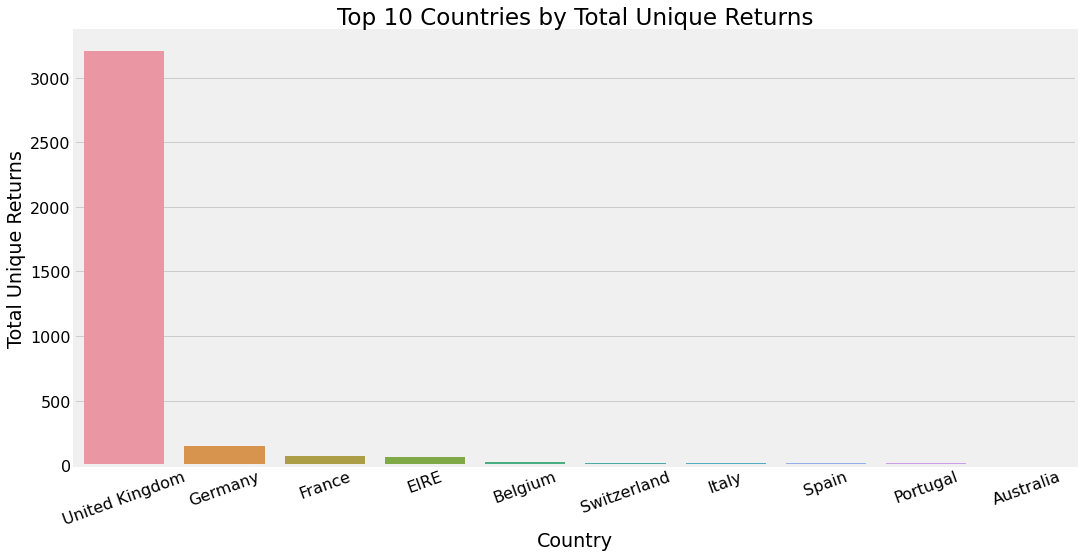

In [122]:
bar_plot(top_returns, "Country", "InvoiceNo", "Country", "Total Unique Returns", 
         "Top 10 Countries by Total Unique Returns")

Looks like the number of returns made by each country is proportional to the total purchases made by the countries.

In [133]:
# Getting the sum of the unit prices for each country

top_sales = pd.DataFrame(non_return_df.groupby(['Country','Latitude','Longitude'])['UnitPrice']
                                          .sum()
                                          .reset_index(drop=False))

In [134]:
top_sales['UnitPrice'] = total_revenue['UnitPrice'].apply(lambda x: round(x,2))

In [135]:
top_sales.head()

,Country,Latitude,Longitude,UnitPrice
0,Australia,-24.7761086,134.755,3612.50
1,Austria,47.2000338,13.199959,1693.90
2,Bahrain,26.1551249,50.5344606,78.95
3,Belgium,50.6402809,4.6667145,7372.85
4,Brazil,-10.3333333,-53.2,142.60


In [136]:
top_sales = top_sales.sort_values('UnitPrice', ascending=False).head(10).reset_index()

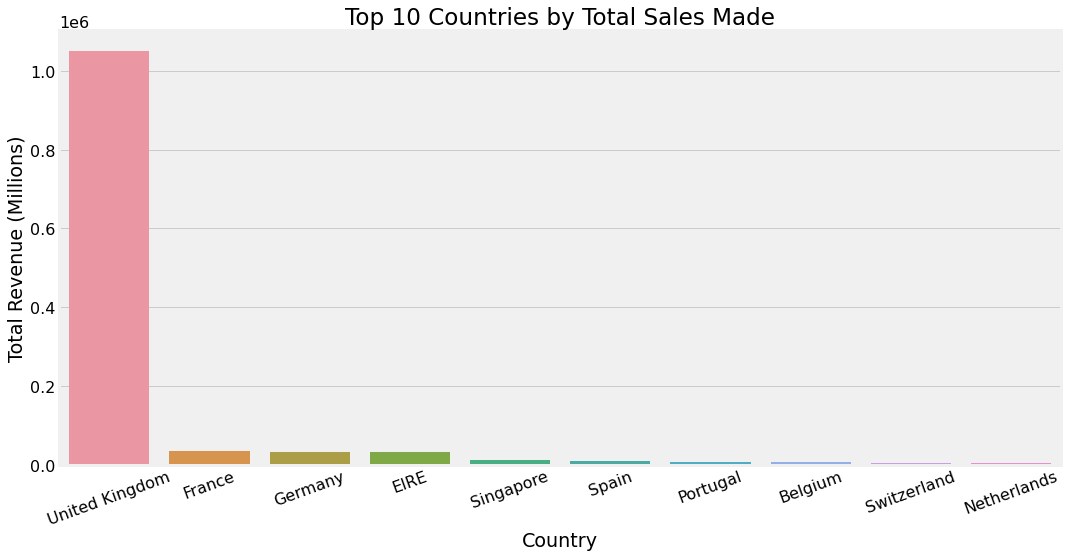

In [150]:
bar_plot(top_sales, "Country", "UnitPrice", "Country", "Total Revenue (Millions of £)", 
         "Top 10 Countries by Total Sales Made")

It is interesting to see that although France has fewer unique purchases than Germany, it still has a higher sales total which could mean that the customers in France have greater price totals at checkout.    

In [156]:
unique_customers = pd.DataFrame(trunc_df.groupby(['Country','Latitude','Longitude'])['CustomerID']
                                  .nunique()
                                  .reset_index(drop=False))

In [157]:
unique_customers.head()

,Country,Latitude,Longitude,CustomerID
0,Australia,-24.7761086,134.755,9
1,Austria,47.2000338,13.199959,11
2,Bahrain,26.1551249,50.5344606,2
3,Belgium,50.6402809,4.6667145,25
4,Brazil,-10.3333333,-53.2,1


In [159]:
top_customers = unique_customers.sort_values('CustomerID', ascending=False).head(10).reset_index()

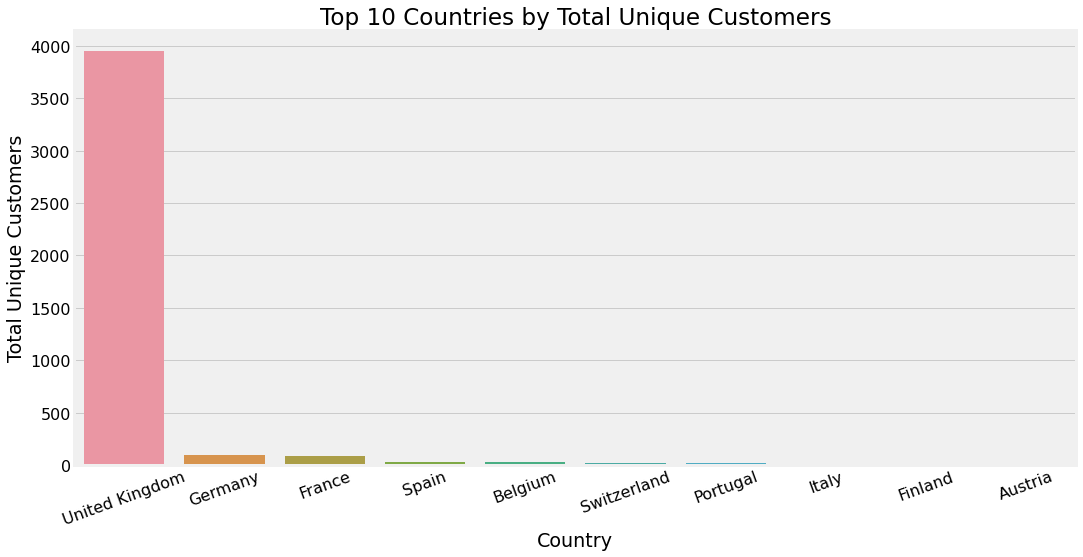

In [160]:
bar_plot(top_customers, "Country", "CustomerID", "Country", "Total Unique Customers", 
         "Top 10 Countries by Total Unique Customers")

It is clear that the UK is the biggest market for this retailer by far, followed by Germany and France. 

<a id="section2b"></a>
## By Customer

We will now take a look at the customer make up of this data. We'll explore:

* How many unique products did customers buy?
* How many total products did customers buy?
* How much money did customers spend?
* How many transactions did customers partake in?

In [198]:
non_return_df['UnitPriceTotal'] = non_return_df['UnitPrice'] * non_return_df['Quantity']

In [230]:
totals = pd.DataFrame(non_return_df.groupby(['CustomerID']).agg({'StockCode':'nunique',
                                                                 'Quantity':'sum',
                                                                 'UnitPriceTotal':'sum',
                                                                 'InvoiceNo':'nunique'})).reset_index()

In [231]:
totals.sort_values('StockCode', ascending=False).head(10)[['CustomerID','StockCode']]

,CustomerID,StockCode
1880,14911.0,1787
326,12748.0,1768
4011,17841.0,1323
1290,14096.0,1119
1435,14298.0,884
1662,14606.0,819
1780,14769.0,718
1334,14156.0,714
1690,14646.0,701
562,13089.0,636


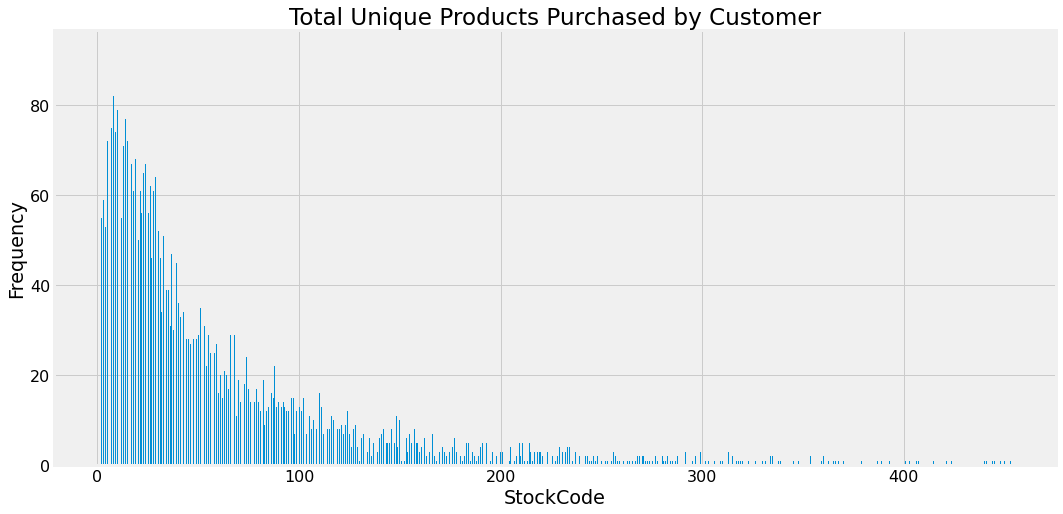

In [232]:
less_500 = totals[totals['StockCode'] < 500]
freq_plot(less_500, 'StockCode', title="Total Unique Products Purchased by Customer", 
          x_label="Total Unique Products", y_label=None, bins=1000)

In [233]:
totals.sort_values('Quantity', ascending=False).head(10)[['CustomerID','Quantity']]

,CustomerID,Quantity
1690,14646.0,197491
3009,16446.0,80997
1880,14911.0,80515
55,12415.0,77670
0,12346.0,74215
3729,17450.0,69993
3772,17511.0,64549
4202,18102.0,64124
997,13694.0,63312
1435,14298.0,58343


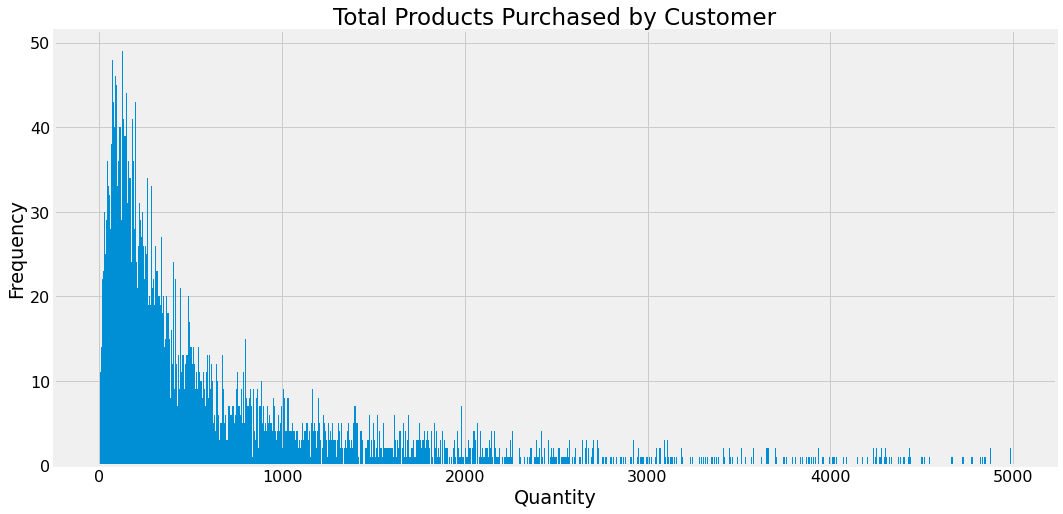

In [234]:
less_5000 = totals[totals['Quantity'] < 5000]
freq_plot(less_5000, 'Quantity', title="Total Products Purchased by Customer", 
          x_label=None, y_label=None, bins=1000)

In [235]:
totals.sort_values('UnitPriceTotal', ascending=False).head(10)[['CustomerID','UnitPriceTotal']]

,CustomerID,UnitPriceTotal
1690,14646.0,280206.02
4202,18102.0,259657.30
3729,17450.0,194550.79
3009,16446.0,168472.50
1880,14911.0,143825.06
55,12415.0,124914.53
1334,14156.0,117379.63
3772,17511.0,91062.38
2703,16029.0,81024.84
0,12346.0,77183.60


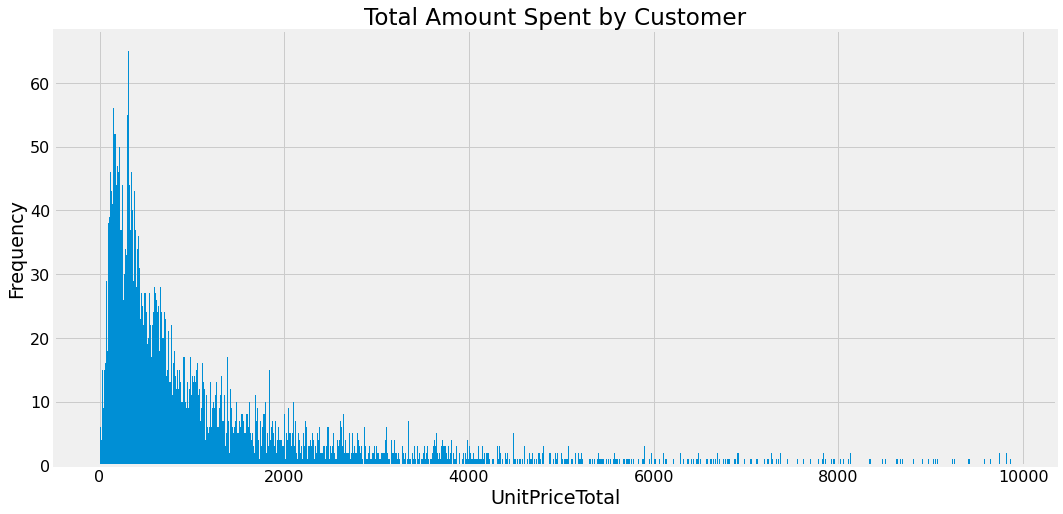

In [236]:
less_10000 = totals[totals['UnitPriceTotal'] < 10000]
freq_plot(less_10000, 'UnitPriceTotal', title="Total Amount Spent by Customer", 
          x_label="Total Amout Spent (£)", y_label=None, bins=1000)

In [237]:
less_10000 = totals[totals['UnitPriceTotal'] < 10000]
totals.sort_values('InvoiceNo', ascending=False).head(10)[['CustomerID','InvoiceNo']]

,CustomerID,InvoiceNo
326,12748.0,210
1880,14911.0,201
4011,17841.0,124
562,13089.0,97
1662,14606.0,93
2177,15311.0,91
481,12971.0,86
1690,14646.0,74
2703,16029.0,63
796,13408.0,62


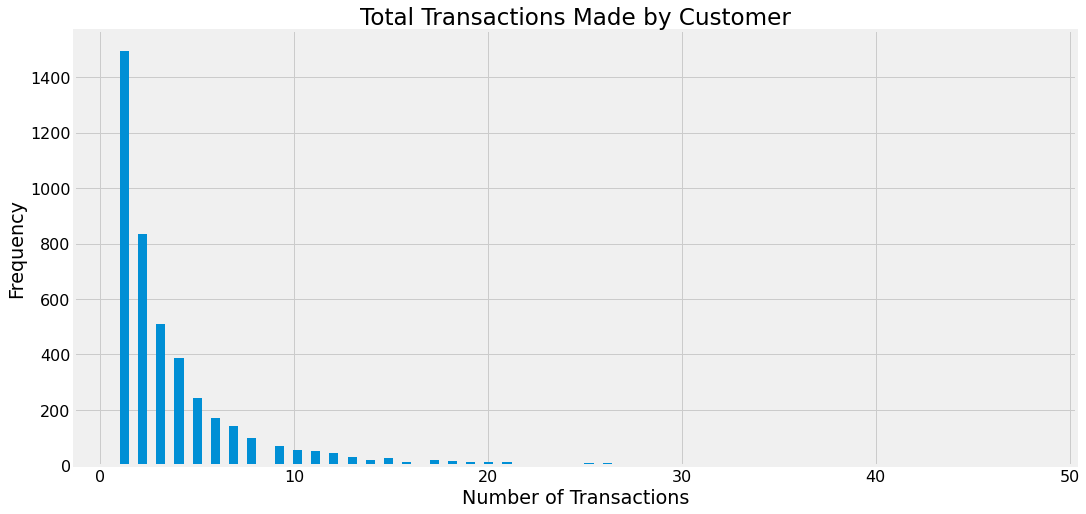

In [241]:
less_50 = totals[totals['InvoiceNo'] < 50]
freq_plot(less_50, 'InvoiceNo', title="Total Transactions Made by Customer", 
          x_label='Number of Transactions', y_label=None, bins=100)

Nothing remarkable here, all of the graphs here are positively skewed as expected. 

<a id="section2c"></a>
## By Transaction

We will now take a look at the transaction make up of this data. We'll explore:

* How many unique products are purchased per transaction?
* How many total products are purchased per transaction?
* How much money is spent per transaction?

In [210]:
per_trans = pd.DataFrame(non_return_df.groupby(['InvoiceNo']).agg({'StockCode':'nunique',
                                                                    'Quantity':'sum',
                                                                    'UnitPriceTotal':'sum'})).reset_index()

In [214]:
per_trans.sort_values('StockCode', ascending=False).head(10)[['CustomerID','StockCode']]

,CustomerID,StockCode
5629,14096.0,541
5631,14096.0,529
5632,14096.0,525
5630,14096.0,439
5627,14096.0,434
5620,14096.0,419
7896,14769.0,386
5628,14096.0,375
5624,14096.0,363
5625,14096.0,352


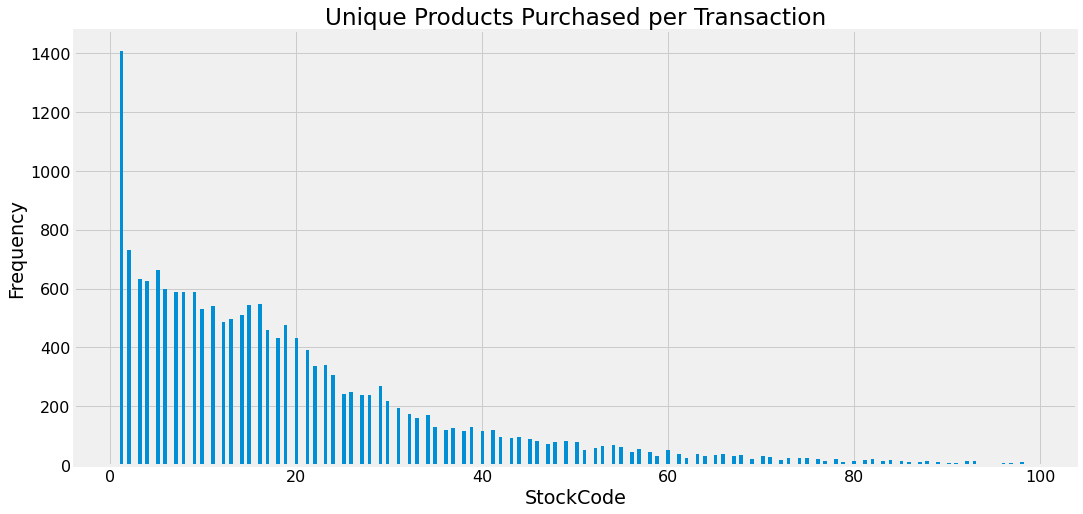

In [223]:
less_100 = per_trans[per_trans['StockCode'] < 100]
freq_plot(less_100, 'StockCode', title="Unique Products Purchased per Transaction", 
          x_label=None, y_label=None, bins=250)

In [216]:
per_trans.sort_values('Quantity', ascending=False).head(10)[['CustomerID','Quantity']]

,CustomerID,Quantity
12891,16446.0,80995
0,12346.0,74215
164,12415.0,15049
7423,14646.0,14730
7438,14646.0,13392
15870,17450.0,12572
3156,13256.0,12540
7408,14646.0,12266
169,12415.0,12196
1980,12931.0,11848


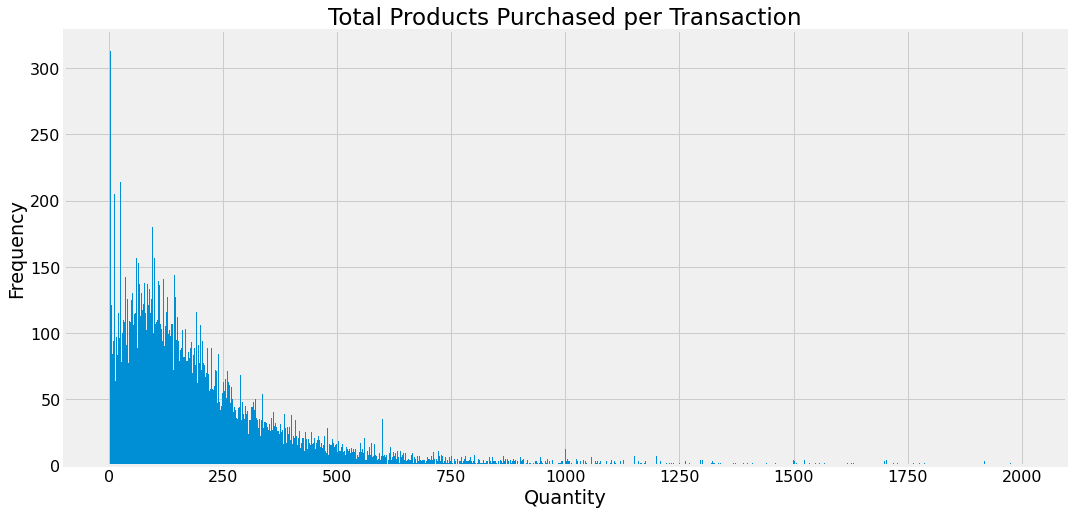

In [225]:
less_2000 = per_trans[per_trans['Quantity'] < 2000]
freq_plot(less_2000, 'Quantity', title="Total Products Purchased per Transaction", 
          x_label=None, y_label=None, bins=1000)

In [218]:
per_trans.sort_values('UnitPriceTotal', ascending=False).head(10)[['CustomerID','UnitPriceTotal']]

,CustomerID,UnitPriceTotal
12891,16446.0,168469.60
0,12346.0,77183.60
9022,15098.0,38970.00
15870,17450.0,31698.16
164,12415.0,22775.93
18016,18102.0,22206.00
15867,17450.0,22104.80
169,12415.0,21880.44
10900,15749.0,21535.90
7438,14646.0,20277.92


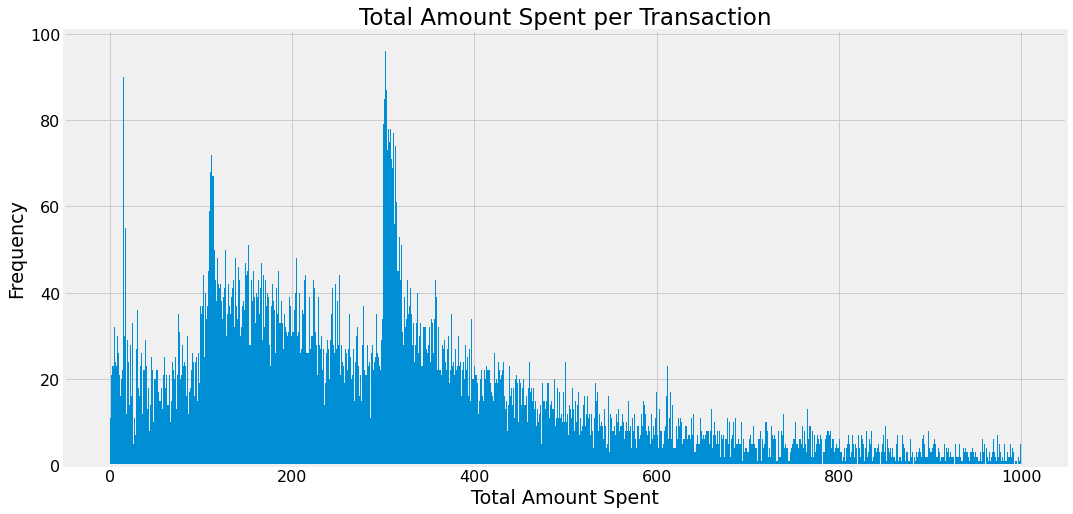

In [228]:
less_1000 = per_trans[per_trans['UnitPriceTotal'] < 1000]
freq_plot(less_1000, 'UnitPriceTotal', title="Total Amount Spent per Transaction", 
          x_label="Total Amount Spent (£)", y_label=None, bins=1000)

It seems like, on average, there are many customers who buy in bulk; buying a large quantity of a few specific items. Furthermore, there looks to be 3 distinct groups of shoppers which can be seen as the 3 prominent spikes on the 'Total Amount Spent per Transaction' graph. You have shoppers that spend around 20, 100, and 300 dollars.

<a id="section2d"></a>
## By Product

We will now take a look at the products of this data. We'll explore:

* What are the top selling products (in total revenue)?
* What are the top selling products (in quantity sold)?

Here, we will use all of the data since we are not concerned with the individual customers.

In [353]:
non_return_df = df[~df['InvoiceNo'].str.contains("C")].reset_index(drop=True)

In [354]:
non_return_df['UnitPriceTotal'] = non_return_df['UnitPrice'] * non_return_df['Quantity']

In [249]:
products = pd.DataFrame(non_return_df.groupby(['StockCode','Description']).agg({'Quantity':'sum',
                                                                                'UnitPriceTotal':'sum'})).reset_index()

In [251]:
top_products_sale = products.sort_values('UnitPriceTotal', ascending=False).head(10).reset_index()

In [252]:
top_products_qty = products.sort_values('Quantity', ascending=False).head(10).reset_index()

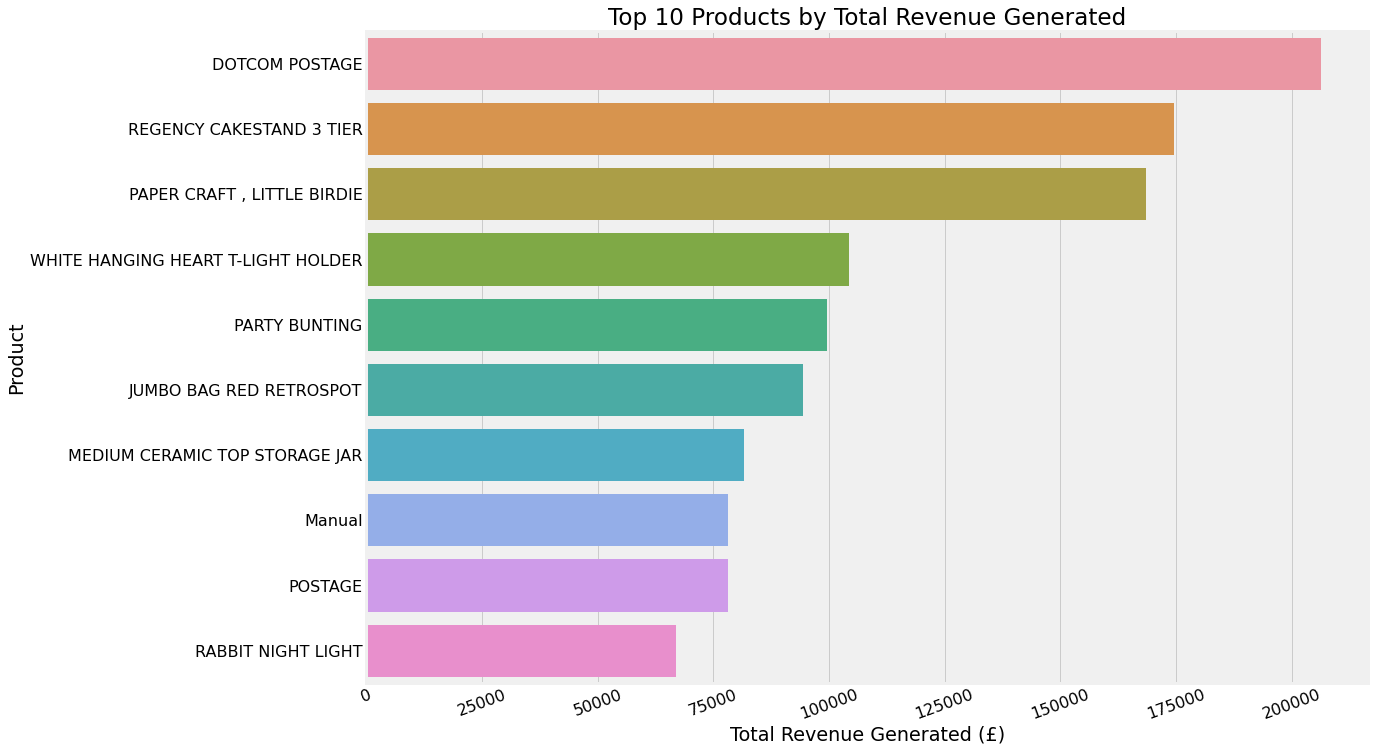

In [268]:
bar_plot(top_products_sale, "UnitPriceTotal","Description", "Total Revenue Generated (£)", "Product", 
         "Top 10 Products by Total Revenue Generated", horizontal = True)

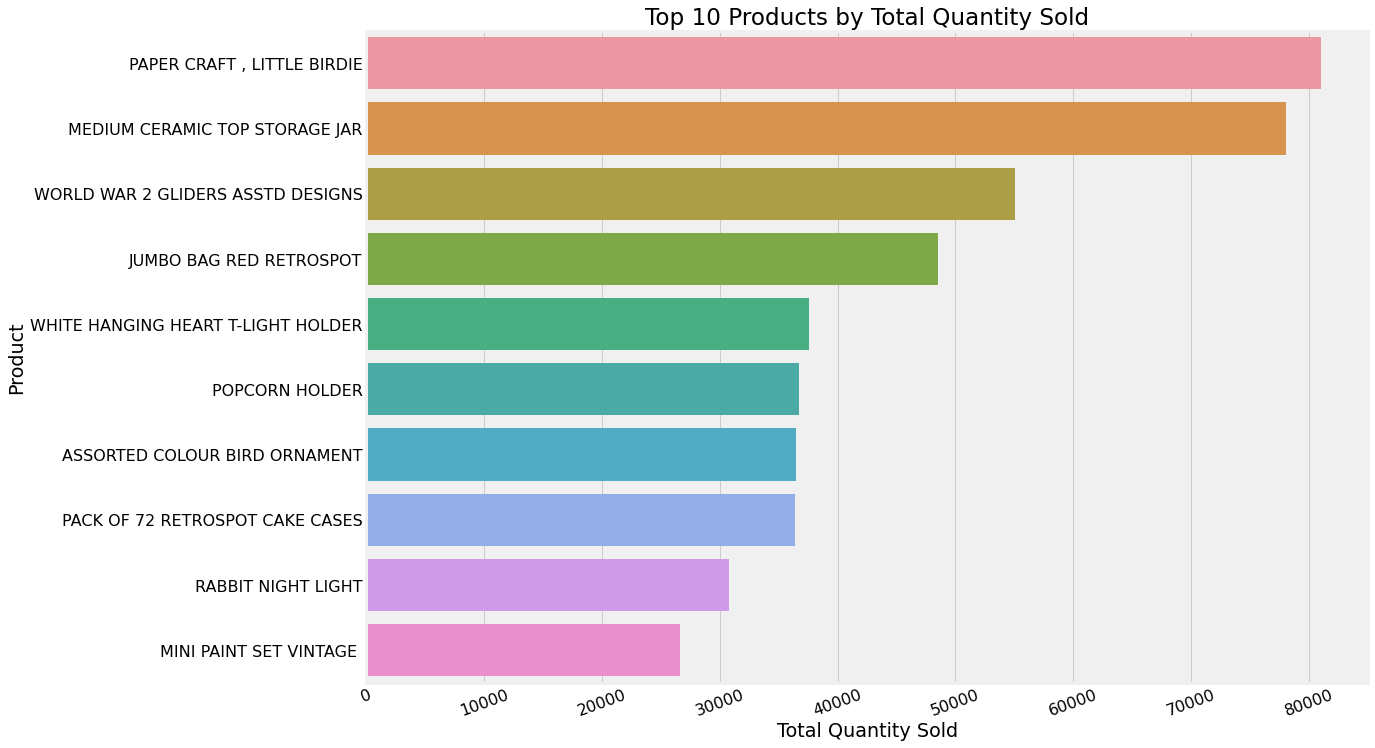

In [266]:
bar_plot(top_products_qty, "Quantity","Description", "Total Quantity Sold", "Product", 
         "Top 10 Products by Total Quantity Sold", horizontal = True)

<a id="section2e"></a>
## By Date

Here we will take a look at a time series of the total transactions made, total revenue gained, and total unique customers to the website over the available dates.

In [398]:
dates = non_return_df.copy()

In [399]:
dates['InvoiceDate'] = dates['InvoiceDate'].apply(lambda x: datetime.strptime(x, '%m/%d/%y'))

In [400]:
dates = pd.DataFrame(dates.groupby(['InvoiceDate']).agg({'Quantity':'sum',
                                                         'UnitPriceTotal':'sum',
                                                         'CustomerID':'nunique'}))

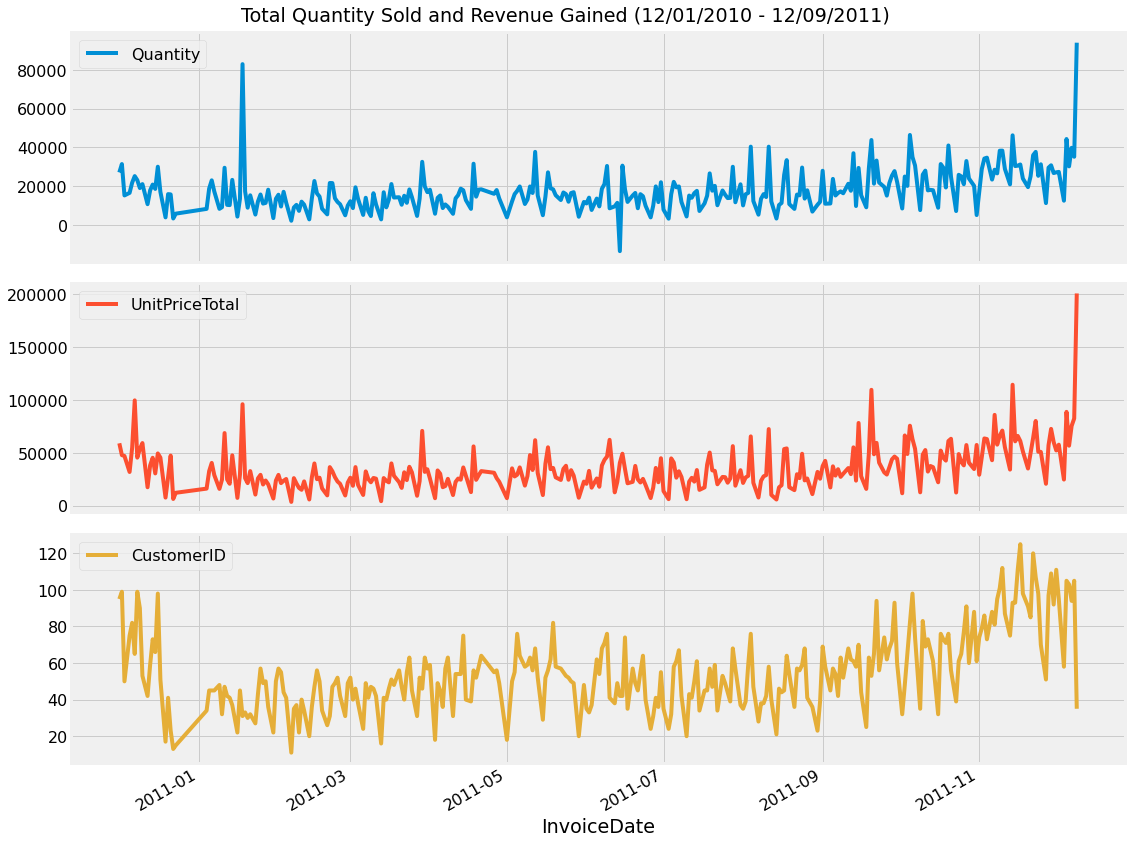

In [401]:
dates.plot(subplots=True, layout=(3,1), figsize=(16,12))
plt.rcParams.update({'font.size': 16})
plt.suptitle('Total Quantity Sold and Revenue Gained (12/01/2010 - 12/09/2011)')
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

There looks to be a steady positive trend in the metrics after September of 2011 and shoots up in December of 2011, likely due to the holiday season. There are notable spikes for the quantity sold in January of 2011 and a small dip in June of 2011. It does seem like the retailer is gaining new customers as is evident by the increase in the average number of unique visitors they receive each day.

<a id="section3"></a>
# Product Clustering

The best way to cluster our customers will be based on the type of products they purchase. There are way too many individual products to take into account, so we will need to cluster the products into their own groups before we can continue with clustering the customers.

The best way to group the products will be by price range and by the keywords that appear in the product description.

### Splitting the products by price range.

In [443]:
non_return_df = trunc_df[~trunc_df['InvoiceNo'].str.contains("C")].reset_index(drop=True)
non_return_df['UnitPriceTotal'] = non_return_df['UnitPrice'] * non_return_df['Quantity'] 
non_return_df['InvoiceDate'] = non_return_df['InvoiceDate'].apply(lambda x: datetime.strptime(x, '%m/%d/%y'))

In [470]:
# Look at the price distribution of the products

product = non_return_df[['StockCode','UnitPrice']].drop_duplicates(['StockCode','UnitPrice'])

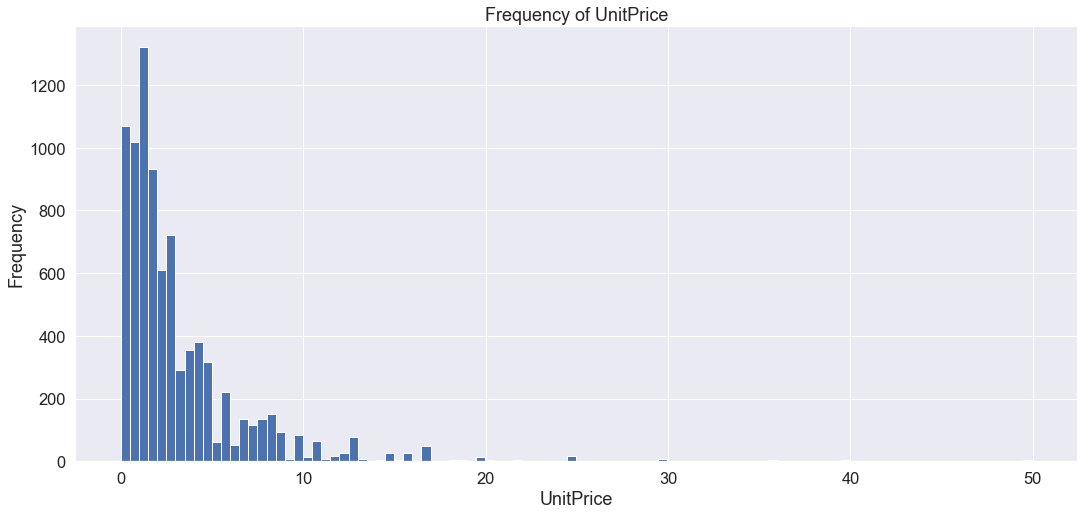

In [475]:
less_50 = product[product['UnitPrice'] < 50]
freq_plot(less_50, 'UnitPrice', title=None, x_label=None, y_label=None, bins=100)

In [507]:
product['UnitPrice'] = product['UnitPrice'].astype(float)
product['PriceCuts'] = product['UnitPrice'].apply(lambda x: assign_class(x))

In [509]:
product.groupby('PriceCuts').count()

,StockCode,UnitPrice
PriceCuts,,
class_1,2089,2089
class_2,2253,2253
class_3,1333,1333
class_4,1343,1343
class_5,1058,1058
class_6,509,509


In [515]:
classes = pd.get_dummies(product['PriceCuts'], columns=['PriceCuts'], drop_first=True) 

In [602]:
product_prices = product.join(classes, how = 'left')

In [604]:
product_prices = product_prices.drop_duplicates('StockCode').reset_index(drop=True)
del product_prices['PriceCuts']
del product_prices['UnitPrice']

### Splitting the products based on keywords

In [661]:
product_desc = non_return_df[['StockCode','Description']].drop_duplicates(['StockCode']).reset_index(drop=True)

In [662]:
non_return_df[['StockCode']].nunique()

StockCode    3665
dtype: int64

In [665]:
product_desc['Description'] = product_desc['Description'].apply(desc_to_words)

In [666]:
product_desc_og = product_desc.copy()

In [593]:
# Creating the Bag of Words model 
word2count = {} 
for desc in product_desc['Description']: 
    words = nltk.word_tokenize(desc) 
    for word in words: 
        if word not in word2count.keys(): 
            word2count[word] = 1
        else: 
            word2count[word] += 1

In [594]:
freq_words = heapq.nlargest(100, word2count, key=word2count.get)

In [595]:
X = [] 
for desc in product_desc['Description']:  
    vector = [] 
    for word in freq_words: 
        if word in nltk.word_tokenize(desc): 
            vector.append(1) 
        else: 
            vector.append(0) 
    X.append(vector) 
X = np.asarray(X)

In [596]:
product_desc = product_desc.reset_index(drop=True)

In [597]:
product_desc = product_desc.join(pd.DataFrame(X), how='left')   
del product_desc['Description']

In [598]:
product_desc = product_desc.drop_duplicates()

Now, to merge the price and keyword breakdowns of the products

In [609]:
product_final = product_prices.merge(product_desc, how='left', on='StockCode')

<a id="section3a"></a>
### PCA

In [612]:
# Performing PCA

pca = PCA(n_components = None)
pca_fit = pca.fit_transform(product_final.iloc[:,1:])
explained_var = pca.explained_variance_ratio_

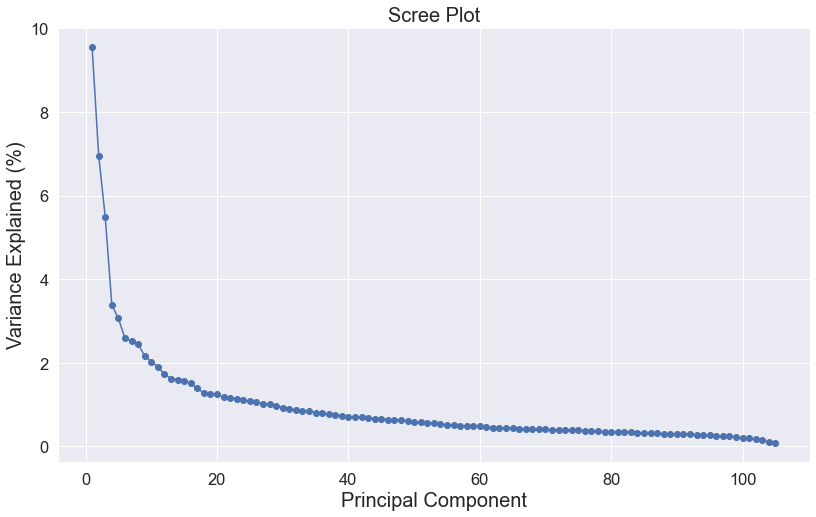

In [620]:
# Scree Plot

sns.set(font_scale = 1.5)
plt.figure(figsize=(12,8))
sns.scatterplot(x = range(1,106), y = (explained_var*100), color = 'black')
plt.plot(range(1,106), ((explained_var*100)),'-o')
plt.title('Scree Plot', fontsize=20)
plt.xlabel('Principal Component', fontsize=20)
plt.ylabel('Variance Explained (%)', fontsize=20)
plt.show();

In [622]:
# Calculating cumulative variance 
cum_var = []

for i in range(0,len(explained_var)):
    if i == 0:
        element = explained_var[i]*100 
        cum_var.append(element)
    if i > 0:
        element = explained_var[i]*100 
        element = element + cum_var[i-1]
        cum_var.append(element)

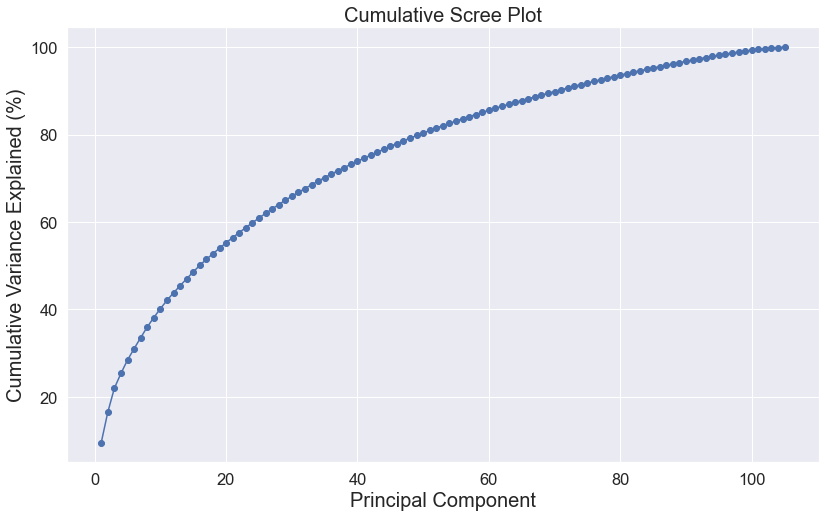

In [625]:
# Cumulative Scree Plot

sns.set(font_scale = 1.5)
plt.figure(figsize=(12,8))
sns.scatterplot(x = range(1,106), y = cum_var[0:106], color = 'black')
plt.plot(range(1,106), (cum_var[0:106]),'-o')
plt.title('Cumulative Scree Plot', fontsize=20)
plt.xlabel('Principal Component', fontsize=20)
plt.ylabel('Cumulative Variance Explained (%)', fontsize=20)
plt.show();

<a id="section3b"></a>
### Clustering

In [629]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(pca_fit)
y_kmeans = kmeans.predict(pca_fit)

In [645]:
len(y_kmeans)

3665

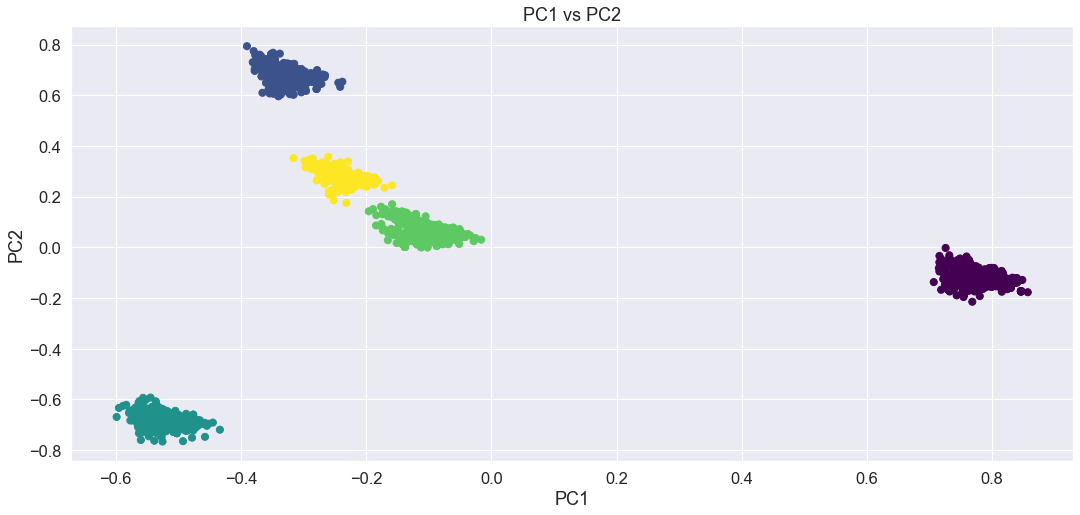

In [640]:
plt.figure(figsize=(16,8))
plt.scatter(pca_fit[:, 0], pca_fit[:, 1], c=y_kmeans, s=50, cmap='viridis')
plt.xlabel('PC1');
plt.ylabel('PC2');
plt.title('PC1 vs PC2');

We see that the products can be clearly separated into 5 groups. Let's now analyze the most common words that appear in the descriptions of each cluster.

In [668]:
product_cat = product_desc_og.join(pd.DataFrame(y_kmeans), how='left')

In [670]:
product_cat.columns = ['StockCode', 'Description', 'Category']

In [689]:
cat_desc_dict = {}
for i in range(5):
    cat_desc_dict[i] = " ".join(pd.Series.tolist(product_cat.loc[(product_cat['Category'] == i), 'Description']))

In [709]:
# Create and generate a word cloud image:

stops = set(stopwords.words("english"))

# Excluding colors and words that appear often across all categories

add_words = ['white', 'blue', 'pink', 'black', 'green', 'red', 'set', 'heart']
for word in add_words:
    stops.add(word)

word_clouds = {}
color_maps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
for i in range(5):
    word_clouds[i] = WordCloud(max_words=100, background_color="white", colormap=color_maps[i],
                     width = 400, height = 300, stopwords=stops).generate(cat_desc_dict[i])

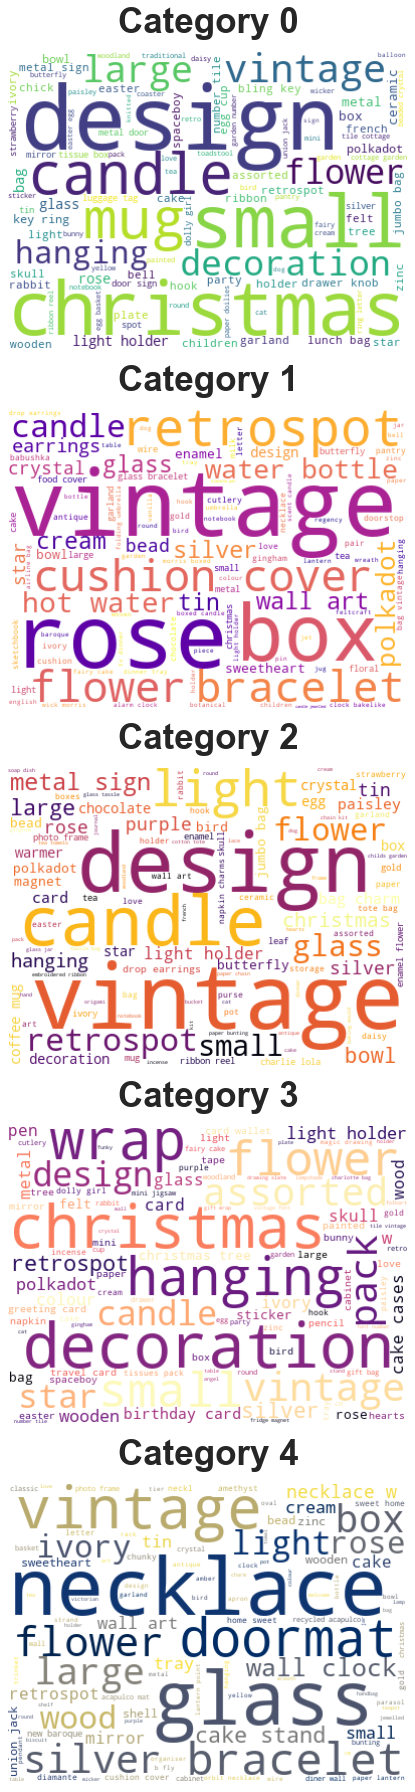

In [710]:
# Display the generated image:

fig, ax = plt.subplots(5,1,figsize=(30,25))

for i in range(5):
    
    plt.subplot(5,1,i+1)
    plt.imshow(word_clouds[i], interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Category {i}", fontsize = 35, weight = 'bold', pad = 20)

plt.tight_layout()

plt.show()

We see that the price ranges we created separate our products into neat groups with the description keywords adding variation within each group. Looking at the word clouds, it looks like each group holds increasingly more expensive items, as expected. Category 0 items include (Christmas) decorations, mugs, candles, and "small" objects while Category 4 items include antique items made of ivory, silver, and wood.

<a id="section4"></a>
# Customer Clustering

The final goal of this analysis is to create a model that will place customers into groups based on their spending habits. That is, assuming that there are predictable spending habits amongst the customers that will allow us to divide them into archetypes.

In order to obtain labels for our groups we will need to perform a cluster analysis. Before we do this we will need to decide what metrics we will cluster our customers on. Here are the features we will use:

* Median Basket Price
* Median Basket Quantity
* Median Unique Item
* Days Since First Purchase
* Days Since Last Purchase
* Proportion of total amount spent in each product category

In [717]:
non_return_df_new = non_return_df.merge(product_cat, how='left', on='StockCode')[['InvoiceNo','StockCode','Quantity','InvoiceDate','UnitPrice','CustomerID','UnitPriceTotal','Category']]

In [720]:
for i in range(5):
    col = 'cat_{}'.format(i)        
    df_temp = non_return_df_new[non_return_df_new['Category'] == i]
    price_temp = df_temp['UnitPriceTotal']
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    non_return_df_new.loc[:, col] = price_temp
    non_return_df_new[col].fillna(0, inplace = True)

In [722]:
del non_return_df_new['Category']

In [724]:
agg_df = non_return_df_new.groupby(['CustomerID', 'InvoiceNo']).agg({'StockCode':'nunique',
                                                                      'Quantity':'sum',
                                                                      'UnitPriceTotal':'sum',
                                                                      'InvoiceDate':['min','max'],
                                                                      'cat_0':'sum',
                                                                      'cat_1':'sum',
                                                                      'cat_2':'sum',
                                                                      'cat_3':'sum',
                                                                      'cat_4':'sum'}).reset_index()

In [726]:
agg_df.columns = [' '.join(col).strip() for col in agg_df.columns.values]

In [728]:
final_agg = agg_df.groupby(['CustomerID']).agg({'StockCode nunique':'median',
                                                'Quantity sum':'median',
                                                'UnitPriceTotal sum':'median',
                                                'InvoiceNo':'nunique',
                                                'InvoiceDate min':'min',
                                                'InvoiceDate max':'max',
                                                'cat_0 sum':'sum',
                                                'cat_1 sum':'sum',
                                                'cat_2 sum':'sum',
                                                'cat_3 sum':'sum',
                                                'cat_4 sum':'sum'}).reset_index()

In [729]:
final_agg['days_since_first_tran'] =  datetime.strptime('12/9/11', '%m/%d/%y') - final_agg['InvoiceDate min']
final_agg['days_since_last_tran'] =  datetime.strptime('12/9/11', '%m/%d/%y') - final_agg['InvoiceDate max']

In [731]:
del final_agg['InvoiceDate min']
del final_agg['InvoiceDate max']

In [732]:
final_agg['days_since_first_tran'] = final_agg['days_since_first_tran'].dt.days
final_agg['days_since_last_tran'] = final_agg['days_since_last_tran'].dt.days

In [734]:
final_agg['TotalSpent'] = final_agg['cat_0 sum'] + final_agg['cat_1 sum'] + final_agg['cat_2 sum'] + final_agg['cat_3 sum'] + final_agg['cat_4 sum']


In [749]:
final_agg[['cat_0 sum', 'cat_1 sum', 'cat_2 sum', 'cat_3 sum','cat_4 sum']] = final_agg[['cat_0 sum', 'cat_1 sum', 'cat_2 sum', 'cat_3 sum','cat_4 sum']].div(final_agg['TotalSpent'], axis=0)

In [751]:
final_agg.columns = ['CustomerID', 'median_unique_items', 'median_total_items', 'median_total_amount',
                     'total_transactions', 'cat_0_pro', 'cat_1_pro', 'cat_2_pro', 'cat_3_pro',
                     'cat_4_pro', 'days_since_first_tran', 'days_since_last_tran',
                     'total_amount_spent']

In [761]:
final_agg.fillna(0, inplace=True)

In [762]:
final_agg.head()

,CustomerID,median_unique_items,median_total_items,median_total_amount,total_transactions,cat_0_pro,cat_1_pro,cat_2_pro,cat_3_pro,cat_4_pro,days_since_first_tran,days_since_last_tran,total_amount_spent
0,12346.0,1.0,74215.0,77183.60,1,1.000000,0.000000,0.000000,0.000000,0.000000,325,325,77183.60
1,12347.0,24.0,315.0,584.91,7,0.243503,0.291297,0.234501,0.154657,0.076042,367,2,4310.00
2,12348.0,5.5,435.0,338.50,4,0.419532,0.000000,0.000000,0.580468,0.000000,358,75,1797.24
3,12349.0,73.0,631.0,1757.55,1,0.271719,0.107138,0.115798,0.301454,0.203892,18,18,1757.55
4,12350.0,17.0,197.0,334.40,1,0.484450,0.000000,0.279007,0.236543,0.000000,310,310,334.40


<a id="section4a"></a>
### PCA

In [785]:
# Performing PCA

pca = PCA(n_components = None)
pca_fit = pca.fit_transform(final_agg.iloc[:,1:])
explained_var = pca.explained_variance_ratio_

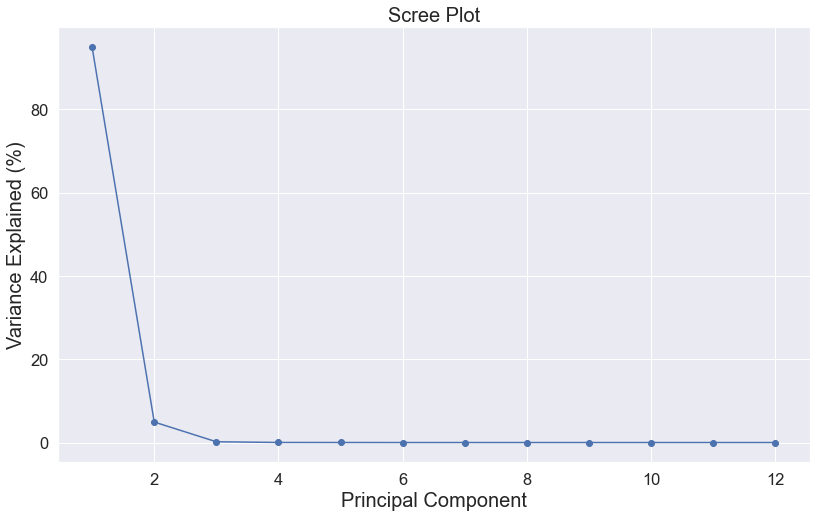

In [786]:
# Scree Plot

sns.set(font_scale = 1.5)
plt.figure(figsize=(12,8))
sns.scatterplot(x = range(1,13), y = (explained_var*100), color = 'black')
plt.plot(range(1,13), ((explained_var*100)),'-o')
plt.title('Scree Plot', fontsize=20)
plt.xlabel('Principal Component', fontsize=20)
plt.ylabel('Variance Explained (%)', fontsize=20)
plt.show();

<a id="section4b"></a>
### Clustering

In [787]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(pca_fit)
y_kmeans = kmeans.predict(pca_fit)

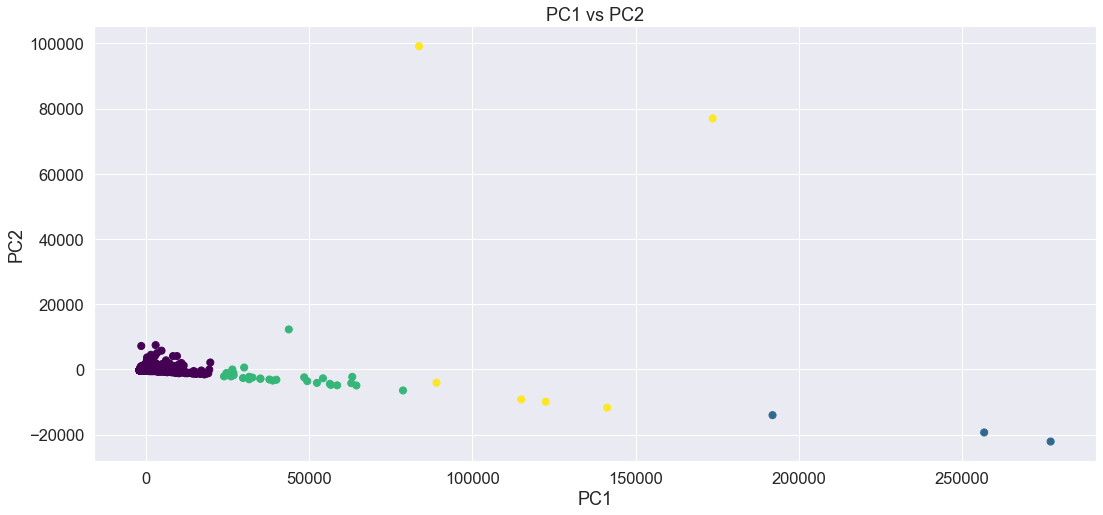

In [788]:
plt.figure(figsize=(16,8))
plt.scatter(pca_fit[:, 0], pca_fit[:, 1], c=y_kmeans, s=50, cmap='viridis')
plt.xlabel('PC1');
plt.ylabel('PC2');
plt.title('PC1 vs PC2');

The biplot looks very sparse and there are no obvious clusters that we can distinguish. This is likely because, due to the features we decided to use, we introduced a very large amount of variation into the data as well. There is so much variance now that it's difficult to separate the customers in any clear cut way. 

Let's see if we get any clusters when we try and separate the customers based on the proportion of money spent on each category of product alone. 

In [789]:
# Performing PCA

pca = PCA(n_components = None)
pca_fit = pca.fit_transform(final_agg.iloc[:,5:10])
explained_var = pca.explained_variance_ratio_

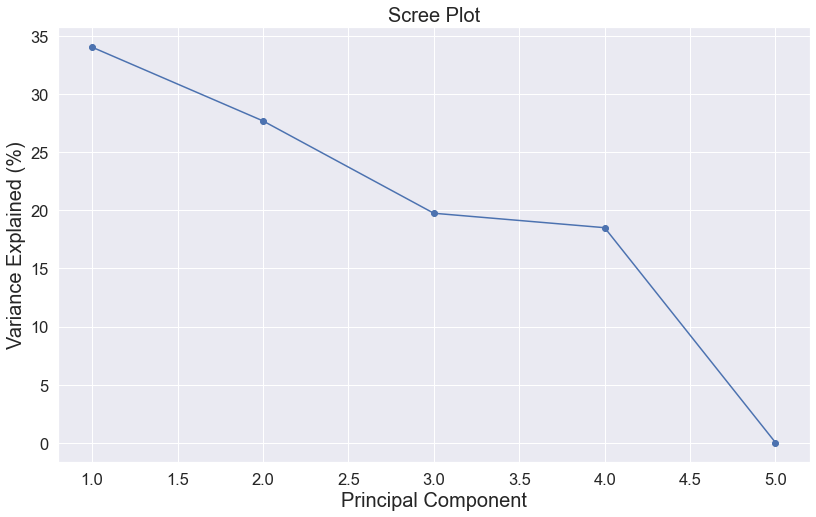

In [790]:
# Scree Plot

sns.set(font_scale = 1.5)
plt.figure(figsize=(12,8))
sns.scatterplot(x = range(1,6), y = (explained_var*100), color = 'black')
plt.plot(range(1,6), ((explained_var*100)),'-o')
plt.title('Scree Plot', fontsize=20)
plt.xlabel('Principal Component', fontsize=20)
plt.ylabel('Variance Explained (%)', fontsize=20)
plt.show();

In [791]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(pca_fit)
y_kmeans = kmeans.predict(pca_fit)

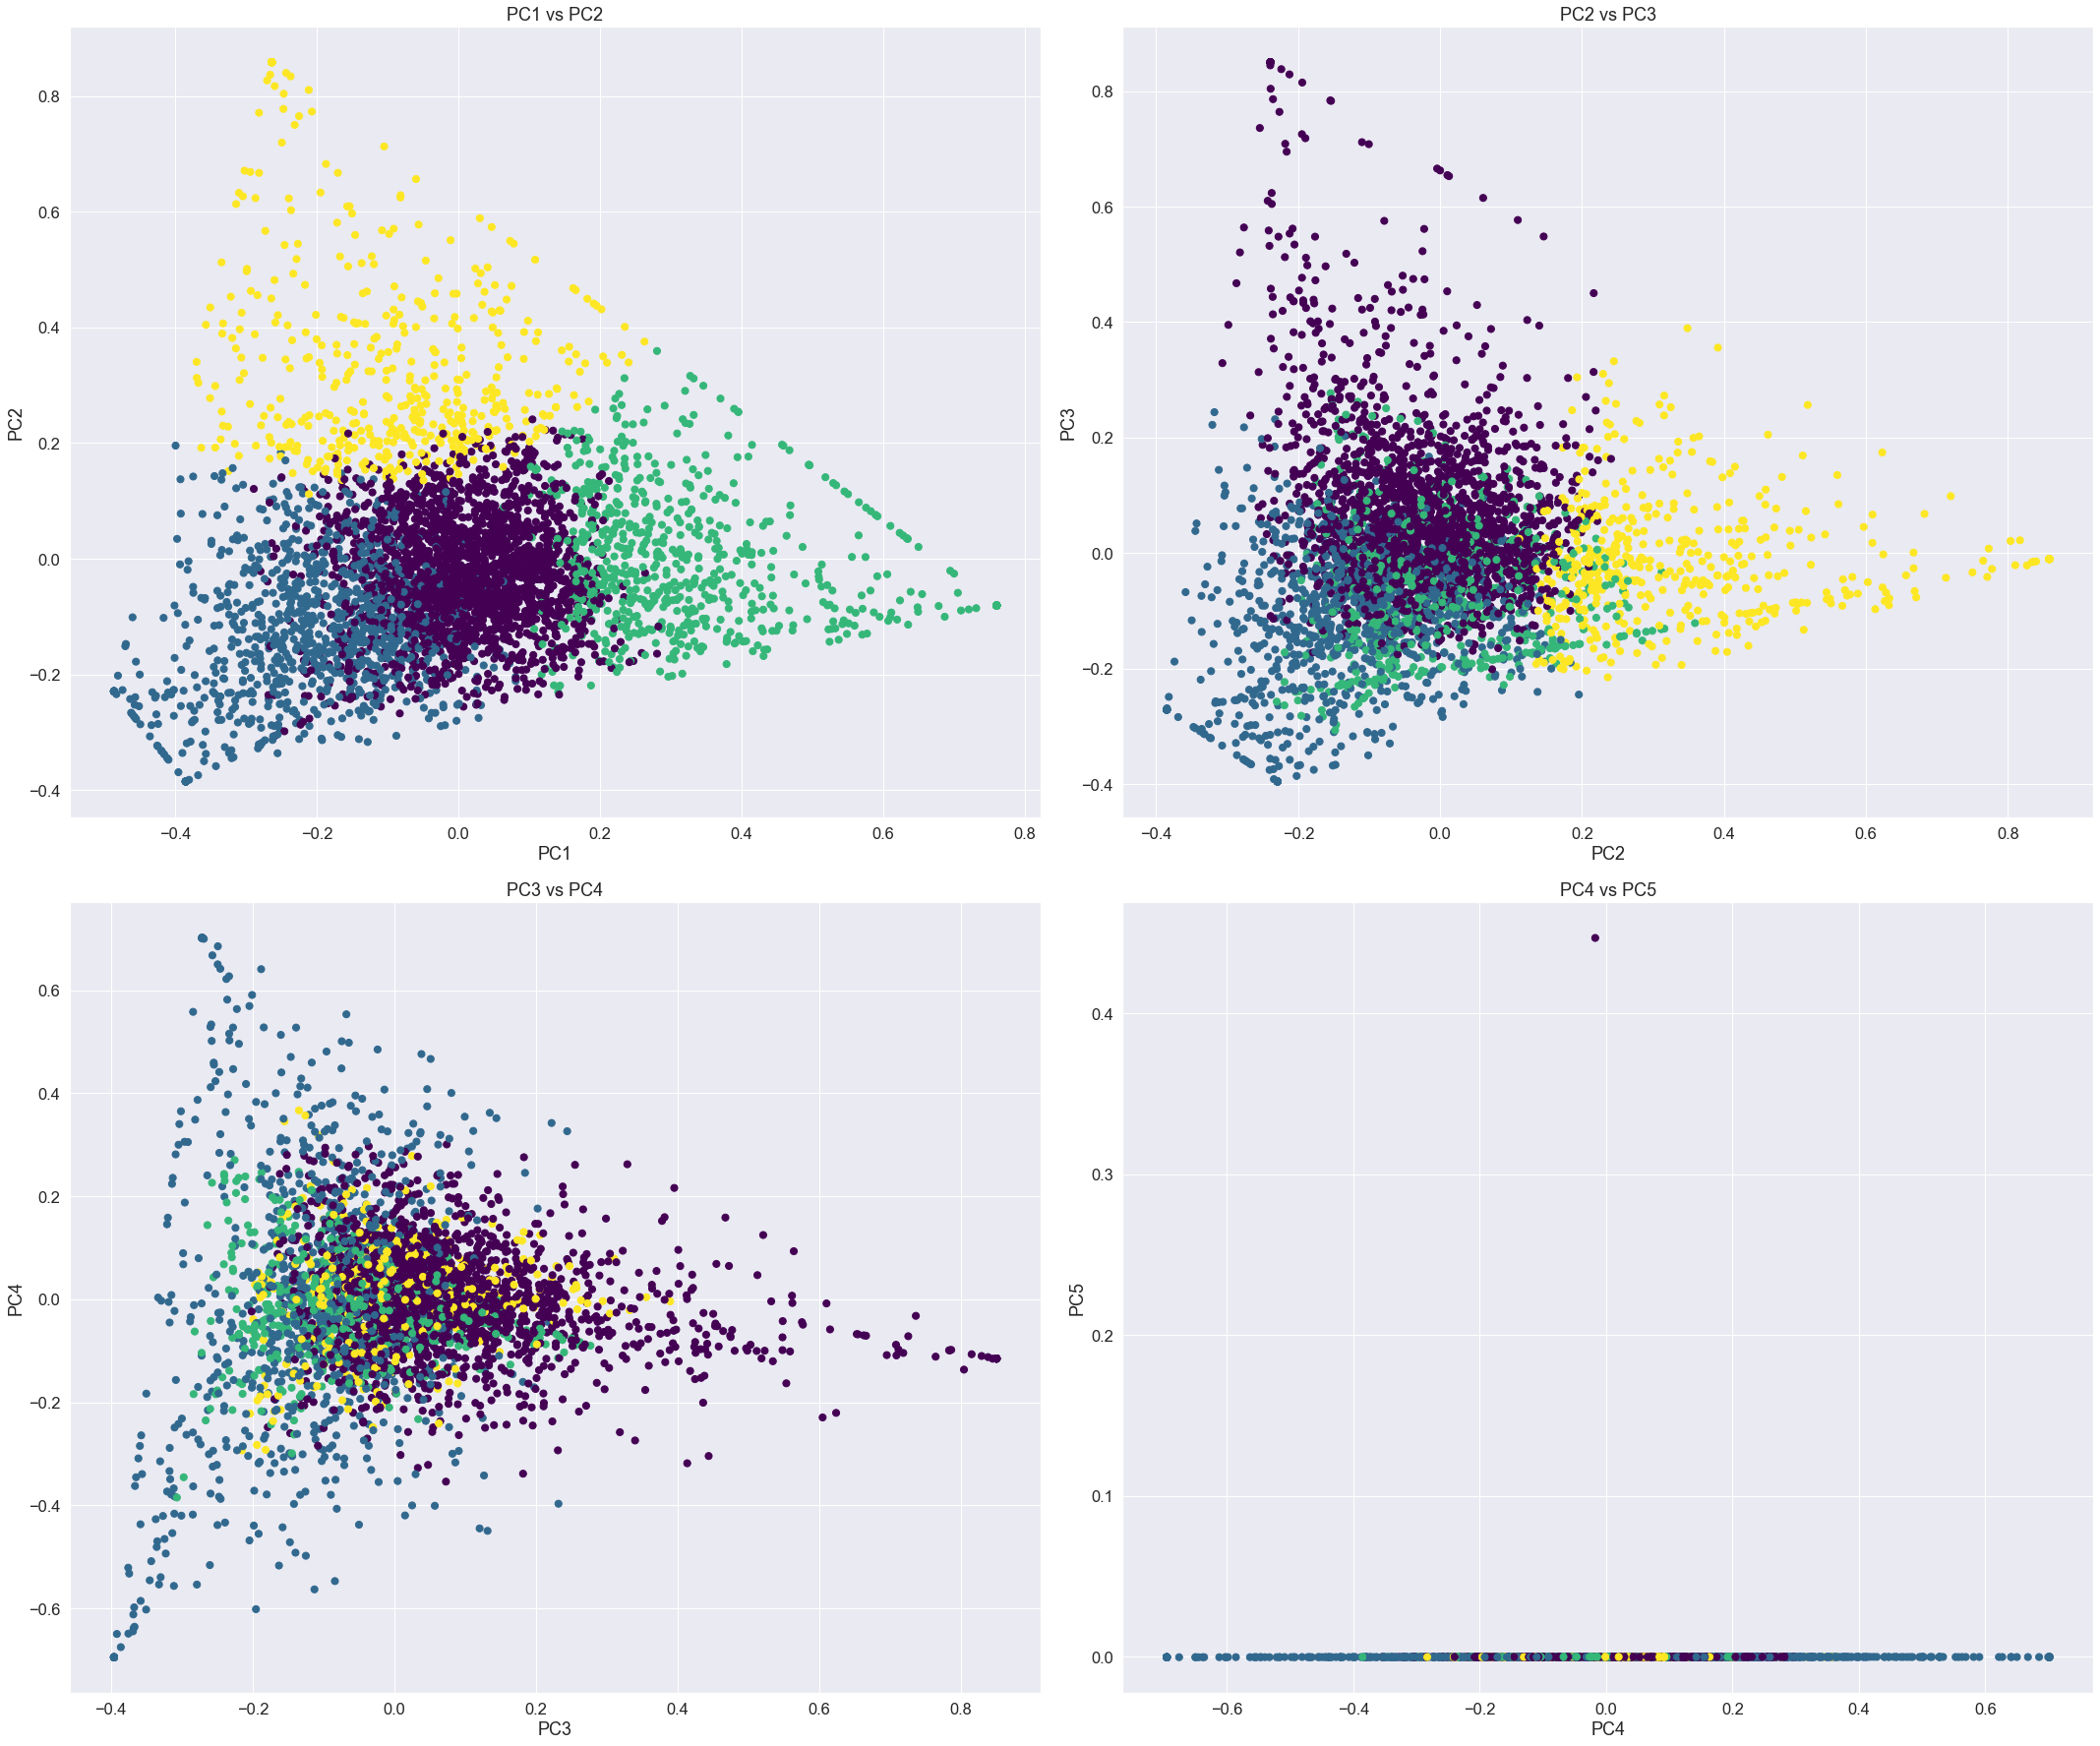

In [795]:
fig, ax = plt.subplots(2,2,figsize=(30,25))

for i in range(4):
    
    plt.subplot(2,2,i+1)
    plt.scatter(pca_fit[:, i], pca_fit[:, i+1], c=y_kmeans, s=50, cmap='viridis')
    plt.xlabel(f'PC{i+1}');
    plt.ylabel(f'PC{i+2}');
    plt.title(f'PC{i+1} vs PC{i+2}');

plt.tight_layout()

plt.show()

Well, what do you know? The graphs now make it much easier to discern specific groupings of the customers. Although, we had to really simplify the features in our data to do so. This is fine, the end goal is to determine what products to recommend customers and this division by product type may just do the job.

<a id="section5"></a>
# Customer Classification

What we want to do now is build a model that will correctly classify our customers into their appropriate classes which we determined in the previous PCA.

To do this, we will use a Logistic Regression model. Based on how well the model performs, we will explore other models to determine if we can achieve a greater accuracy.

In [801]:
final_agg = final_agg.join(pd.DataFrame(y_kmeans), how='left')

In [820]:
final_agg = final_agg[['cat_0_pro','cat_1_pro','cat_2_pro','cat_3_pro','cat_4_pro',0]]

In [822]:
final_agg.columns = ['cat_0_pro', 'cat_1_pro', 'cat_2_pro', 'cat_3_pro', 'cat_4_pro', 'label']

In [871]:
random.seed(101)

test = final_agg.iloc[random.sample(list(final_agg.index), 100)]
train = final_agg[~final_agg.index.isin(list(test.index))]

## Logistic Regression

In [879]:
# Train the model

X_train, y_train = train.iloc[:,:5], train.iloc[:,5]
X_test, y_test = test.iloc[:,:5], test.iloc[:,5]

lr = LogisticRegressionCV(cv=5, random_state=101).fit(X_train, y_train)

In [880]:
# Train set accuracy

lr.score(X_train, y_train)

0.9995281906109932

In [881]:
lr_preds = lr.predict(X_test)

In [882]:
y_test = np.array(y_test)

In [883]:
print(classification_report(y_test, lr_preds))
print(confusion_matrix(y_test, lr_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        48
           1       1.00      1.00      1.00        27
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        10

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

[[48  0  0  0]
 [ 0 27  0  0]
 [ 0  0 15  0]
 [ 0  0  0 10]]


We have successfully created a model that predicts the group that a customer belongs to. We can now take advantage of this to personalize the way we market the retailer's products to the customers, recommending them products that they are likely to buy based on their past purchases.